<a href="https://colab.research.google.com/github/kerlypt05/Proyecto_Inversion_Analisis_de_riesgo_Montecarlo/blob/main/Sistema_nutricional_por_versiones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Version 2.2 Implemenracion de rangos min y max de gramajes por ingredientes

--- Calculadora Nutricional ---

¿Cuántos ingredientes deseas para tu plato? (entre 4 y 8): 6

Alimentos seleccionados (0 de 6 deseados, máx. 8): Ninguno
Ingresa el nombre de un alimento para buscar (o 'list' para ver todos, 'done' para terminar): Arroz
¡'Arroz Blanco (cocido)' añadido!

Alimentos seleccionados (1 de 6 deseados, máx. 8): Arroz Blanco (cocido)
Ingresa el nombre de un alimento para buscar (o 'list' para ver todos, 'done' para terminar): Aguacate
¡'Aguacate Hass' añadido!

Alimentos seleccionados (2 de 6 deseados, máx. 8): Arroz Blanco (cocido), Aguacate Hass
Ingresa el nombre de un alimento para buscar (o 'list' para ver todos, 'done' para terminar): Carne
¡'Carne de Res (posta cocida)' añadido!

Alimentos seleccionados (3 de 6 deseados, máx. 8): Arroz Blanco (cocido), Aguacate Hass, Carne de Res (posta cocida)
Ingresa el nombre de un alimento para buscar (o 'list' para ver todos, 'done' para terminar): Aceite
¡'Aceite de Oliva' añadido!

Alimentos seleccionados (4 de 6 

/tmp/ipython-input-3135100822.py:535: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.85, 0.95]) # Ajustar layout para el título principal y la barra de color


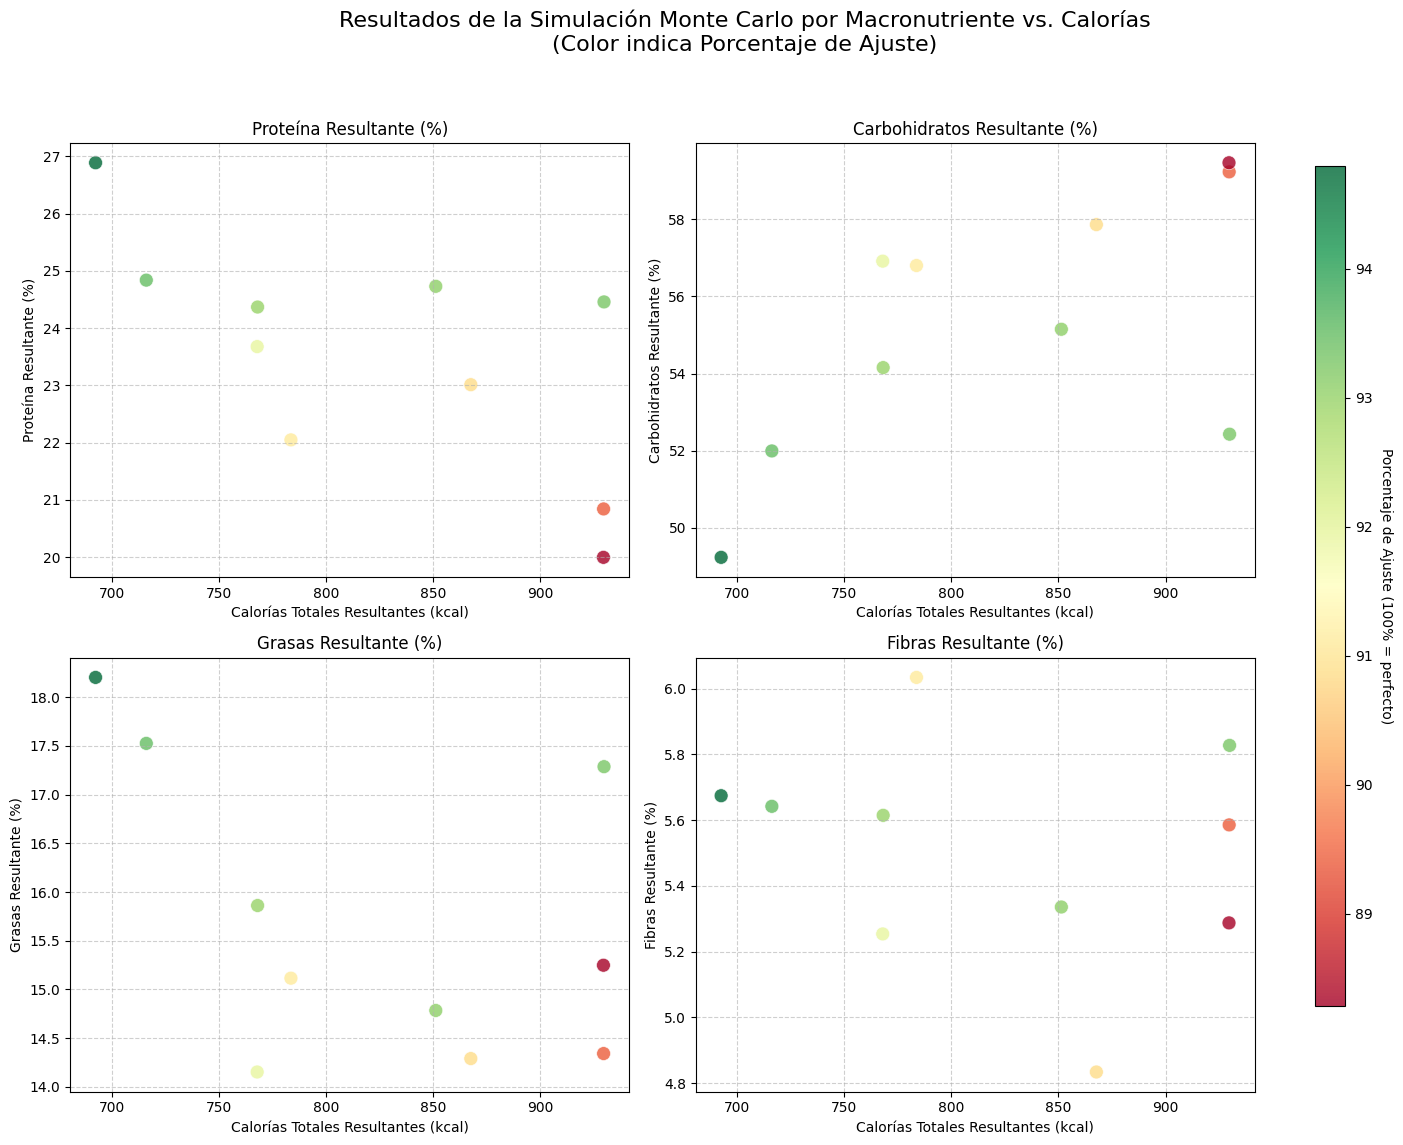

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random # Para la simulación Monte Carlo
from scipy.stats import norm # Para la curva de distribución normal
from scipy.optimize import linprog # Nuevo: para optimización lineal

# Densidades calóricas por gramo para cada macronutriente (kcal/g)
CALORIC_DENSITIES = {
    'proteina': 4,
    'carbohidratos': 4,
    'grasas': 9,
    'fibras': 2
}

# Simulación de la Base de Datos de Composición de Alimentos de Colombia (TCAC)
# Ampliada para ofrecer más variedad y AHORA CON min_gramos y max_gramos por alimento.
# Estos son datos de ejemplo y deben ser reemplazados por datos precisos de la TCAC si se usa en un contexto real,
# y los min_gramos/max_gramos son SUGERENCIAS y deben ser ajustados según la lógica culinaria y nutricional.
TCAC_DATABASE = [
    {'nombre': 'Carne de Res (posta cocida)', 'proteina': 0.30, 'carbohidratos': 0.00, 'grasas': 0.10, 'fibras': 0.00, 'min_gramos': 50, 'max_gramos': 200},
    {'nombre': 'Arroz Blanco (cocido)', 'proteina': 0.027, 'carbohidratos': 0.28, 'grasas': 0.003, 'fibras': 0.004, 'min_gramos': 80, 'max_gramos': 250},
    {'nombre': 'Plátano Maduro (cocido)', 'proteina': 0.01, 'carbohidratos': 0.30, 'grasas': 0.003, 'fibras': 0.02, 'min_gramos': 50, 'max_gramos': 200},
    {'nombre': 'Frijol Rojo (cocido)', 'proteina': 0.08, 'carbohidratos': 0.20, 'grasas': 0.005, 'fibras': 0.07, 'min_gramos': 60, 'max_gramos': 200},
    {'nombre': 'Aguacate Hass', 'proteina': 0.02, 'carbohidratos': 0.09, 'grasas': 0.15, 'fibras': 0.07, 'min_gramos': 30, 'max_gramos': 100},
    {'nombre': 'Pechuga de Pollo (cocida)', 'proteina': 0.25, 'carbohidratos': 0.00, 'grasas': 0.03, 'fibras': 0.00, 'min_gramos': 80, 'max_gramos': 250},
    {'nombre': 'Papa (cocida)', 'proteina': 0.02, 'carbohidratos': 0.17, 'grasas': 0.001, 'fibras': 0.02, 'min_gramos': 100, 'max_gramos': 300},
    {'nombre': 'Huevo (cocido)', 'proteina': 0.13, 'carbohidratos': 0.01, 'grasas': 0.11, 'fibras': 0.00, 'min_gramos': 50, 'max_gramos': 150}, # ~1-3 huevos
    {'nombre': 'Lenteja (cocida)', 'proteina': 0.09, 'carbohidratos': 0.20, 'grasas': 0.004, 'fibras': 0.08, 'min_gramos': 60, 'max_gramos': 200},
    {'nombre': 'Tomate (fresco)', 'proteina': 0.009, 'carbohidratos': 0.039, 'grasas': 0.002, 'fibras': 0.012, 'min_gramos': 20, 'max_gramos': 100},
    {'nombre': 'Cebolla (fresca)', 'proteina': 0.011, 'carbohidratos': 0.093, 'grasas': 0.001, 'fibras': 0.017, 'min_gramos': 10, 'max_gramos': 50},
    {'nombre': 'Brócoli (cocido)', 'proteina': 0.028, 'carbohidratos': 0.07, 'grasas': 0.004, 'fibras': 0.026, 'min_gramos': 50, 'max_gramos': 150},
    {'nombre': 'Espinaca (cocida)', 'proteina': 0.029, 'carbohidratos': 0.036, 'grasas': 0.004, 'fibras': 0.022, 'min_gramos': 50, 'max_gramos': 150},
    {'nombre': 'Aceite de Oliva', 'proteina': 0.00, 'carbohidratos': 0.00, 'grasas': 1.00, 'fibras': 0.00, 'min_gramos': 5, 'max_gramos': 30},
    {'nombre': 'Pan Integral', 'proteina': 0.07, 'carbohidratos': 0.40, 'grasas': 0.03, 'fibras': 0.06, 'min_gramos': 30, 'max_gramos': 120}, # ~1-3 rebanadas
    {'nombre': 'Leche Entera', 'proteina': 0.033, 'carbohidratos': 0.047, 'grasas': 0.037, 'fibras': 0.00, 'min_gramos': 100, 'max_gramos': 400},
    {'nombre': 'Pescado (Tilapia al horno)', 'proteina': 0.26, 'carbohidratos': 0.00, 'grasas': 0.03, 'fibras': 0.00, 'min_gramos': 80, 'max_gramos': 250},
    {'nombre': 'Quinoa (cocida)', 'proteina': 0.044, 'carbohidratos': 0.213, 'grasas': 0.019, 'fibras': 0.028, 'min_gramos': 70, 'max_gramos': 200},
    {'nombre': 'Zanahoria (cocida)', 'proteina': 0.006, 'carbohidratos': 0.082, 'grasas': 0.002, 'fibras': 0.028, 'min_gramos': 30, 'max_gramos': 100},
    {'nombre': 'Yogur Griego (natural, descremado)', 'proteina': 0.10, 'carbohidratos': 0.04, 'grasas': 0.004, 'fibras': 0.00, 'min_gramos': 100, 'max_gramos': 300},
    {'nombre': 'Manzana (fresca)', 'proteina': 0.003, 'carbohidratos': 0.138, 'grasas': 0.002, 'fibras': 0.024, 'min_gramos': 50, 'max_gramos': 200},
    {'nombre': 'Avena (cocida)', 'proteina': 0.024, 'carbohidratos': 0.12, 'grasas': 0.014, 'fibras': 0.017, 'min_gramos': 50, 'max_gramos': 150},
    {'nombre': 'Nueces (variadas)', 'proteina': 0.15, 'carbohidratos': 0.14, 'grasas': 0.50, 'fibras': 0.067, 'min_gramos': 10, 'max_gramos': 50},
    {'nombre': 'Espinaca (fresca)', 'proteina': 0.029, 'carbohidratos': 0.036, 'grasas': 0.004, 'fibras': 0.022, 'min_gramos': 30, 'max_gramos': 100},
]


def optimizar_gramaje_nutricional(
    ingredientes_composicion, # Ahora contendrá 'min_gramos' y 'max_gramos'
    proporciones_requeridas,
    requerimiento_calorico_kcal
):
    """
    Optimiza el gramaje de cada ingrediente para un plato utilizando Programación Lineal,
    ajustándose a proporciones de macronutrientes y un requerimiento calórico total.
    La función objetivo es minimizar el peso total del plato.

    Args:
        ingredientes_composicion (dict): Un diccionario donde las claves son los
            nombres de los ingredientes y los valores son diccionarios con su
            composición por gramo, incluyendo 'min_gramos' y 'max_gramos'.
        proporciones_requeridas (dict): Un diccionario con las proporciones deseadas
            para cada macronutriente (en decimales, ej. 0.30 para 30%).
        requerimiento_calorico_kcal (float): El requerimiento calórico total deseado para el plato en kcal.

    Returns:
        dict: Un diccionario con el gramaje calculado para cada ingrediente,
              o None si no se encuentra una solución factible.
    """
    nombres_ingredientes = list(ingredientes_composicion.keys())
    num_ingredientes = len(nombres_ingredientes)

    # Coeficientes de la función objetivo (minimizar el peso total)
    # Queremos minimizar sum(gramajes), así que c = [1, 1, ..., 1]
    c = np.ones(num_ingredientes)

    # Restricciones de igualdad (A_eq * x = b_eq)
    # 1. Restricción calórica total: sum(gramaje_i * kcal_por_gramo_i) = requerimiento_calorico_kcal
    # 2. Restricciones de proporción de macronutrientes:
    #    (P_req * Carbs_total) - (Carbs_req * Proteina_total) = 0
    #    (P_req * Grasas_total) - (Grasas_req * Proteina_total) = 0
    #    (P_req * Fibras_total) - (Fibras_req * Proteina_total) = 0
    #    Asumimos que P_req > 0 para estas proporciones relativas. Si P_req es 0,
    #    se podrían usar otras combinaciones (ej. Carbs_req vs Grasas_req).

    p_req = proporciones_requeridas.get('proteina', 0)
    c_req = proporciones_requeridas.get('carbohidratos', 0)
    f_req = proporciones_requeridas.get('grasas', 0)
    fi_req = proporciones_requeridas.get('fibras', 0)

    # Determinar el macronutriente de referencia para las ecuaciones de proporción.
    # Evita divisiones por cero o coeficientes cero si una proporción requerida es cero.
    macro_ref_val = p_req
    macro_ref_name = 'proteina'

    if macro_ref_val == 0:
        # Si la proteína requerida es 0, buscar el macronutriente con mayor proporción requerida para usar como referencia.
        # Esto es heurístico para asegurar que tengamos un referente no cero para las proporciones.
        max_macro_req = 0
        for macro, req_val in proporciones_requeridas.items():
            if req_val > max_macro_req:
                max_macro_req = req_val
                macro_ref_name = macro
        if macro_ref_name != 'proteina': # Evitar reasignar si ya es proteína
            macro_ref_val = max_macro_req


    if macro_ref_val == 0:
        # Si todas las proporciones requeridas son 0 (o muy cercanas a 0),
        # entonces no se pueden establecer restricciones de proporción significativas.
        # En este caso, solo se usará la restricción calórica.
        # print("Advertencia: Todas las proporciones de macronutrientes requeridas son cero o muy bajas. Solo se aplicará la restricción calórica.")
        A_eq = np.zeros((1, num_ingredientes))
        b_eq = np.zeros(1)
        row_index = 0
    else:
        # Hay 4 restricciones de igualdad: 1 para Kcal, 3 para proporciones (ej. Prot vs Carbs, Prot vs Grasas, Prot vs Fibras)
        A_eq = np.zeros((4, num_ingredientes))
        b_eq = np.zeros(4)
        row_index = 0

    # Llenar la matriz A_eq y el vector b_eq
    kcal_row = np.zeros(num_ingredientes)

    for i, nombre_ingrediente in enumerate(nombres_ingredientes):
        comp = ingredientes_composicion[nombre_ingrediente]
        p_i = comp.get('proteina', 0)
        c_i = comp.get('carbohidratos', 0)
        f_i = comp.get('grasas', 0)
        fi_i = comp.get('fibras', 0)

        # Calculo de calorías por gramo para este ingrediente
        cal_i = (p_i * CALORIC_DENSITIES['proteina'] +
                 c_i * CALORIC_DENSITIES['carbohidratos'] +
                 f_i * CALORIC_DENSITIES['grasas'] +
                 fi_i * CALORIC_DENSITIES['fibras'])
        kcal_row[i] = cal_i

        # Coeficientes para las restricciones de proporción (si aplica)
        # La ecuación es: (MacroX_req * MacroY_i) - (MacroY_req * MacroX_i) = 0
        # Multiplicado por el gramaje del ingrediente.

        # Asegurarse de que el macro de referencia no sea cero para la división implicita en la resta.
        # Las proporciones deben ser proporcionales, no dependientes de la densidad del macro_ref_name.
        # Re-evaluando las restricciones de proporción:
        # P_total / C_total = P_req / C_req => P_total * C_req = C_total * P_req
        # Sum(p_i * x_i) * C_req = Sum(c_i * x_i) * P_req
        # Sum( (p_i * C_req - c_i * P_req) * x_i ) = 0

        # Para Proteína vs. Carbohidratos
        A_eq[row_index + 1, i] = (p_i * c_req) - (c_i * p_req)
        # Para Proteína vs. Grasas
        A_eq[row_index + 2, i] = (p_i * f_req) - (f_i * p_req)
        # Para Proteína vs. Fibras
        A_eq[row_index + 3, i] = (p_i * fi_req) - (fi_i * p_req)


    # Rellenar la primera fila de A_eq con los coeficientes calóricos
    A_eq[row_index, :] = kcal_row
    b_eq[row_index] = requerimiento_calorico_kcal

    # Establecer límites para los gramajes (min_gramos y max_gramos de la base de datos)
    bounds = []
    for nombre_ingrediente in nombres_ingredientes:
        comp = ingredientes_composicion[nombre_ingrediente]
        lower_bound = comp.get('min_gramos', 0) # Si no se define, el mínimo es 0
        upper_bound = comp.get('max_gramos', None) # Si no se define, no hay límite superior

        # Asegurarse de que min_gramos no sea negativo
        lower_bound = max(0, lower_bound)
        bounds.append((lower_bound, upper_bound))

    try:
        # Resolver el problema de programación lineal
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        if res.success:
            gramajes_calculados = {}
            for i, nombre_ingrediente in enumerate(nombres_ingredientes):
                gramajes_calculados[nombre_ingrediente] = round(res.x[i], 2)
            return gramajes_calculados
        else:
            # print(f"Linprog no encontró una solución: {res.message}")
            return None
    except Exception as e:
        # print(f"Error inesperado durante la optimización: {e}")
        return None


def visualizar_proporciones(proporciones_requeridas, ingredientes_composicion, gramajes_calculados):
    """
    Genera un gráfico de barras comparando las proporciones de macronutrientes
    requeridas con las resultantes.
    """
    if not gramajes_calculados:
        print("No hay gramajes calculados para visualizar las proporciones de macronutrientes.")
        return

    # Calcular las cantidades totales de macronutrientes en el plato resultante
    total_proteina = sum(ingredientes_composicion[ing]['proteina'] * gramajes_calculados[ing] for ing in gramajes_calculados)
    total_carbohidratos = sum(ingredientes_composicion[ing]['carbohidratos'] * gramajes_calculados[ing] for ing in gramajes_calculados)
    total_grasas = sum(ingredientes_composicion[ing]['grasas'] * gramajes_calculados[ing] for ing in gramajes_calculados)
    total_fibras = sum(ingredientes_composicion[ing]['fibras'] * gramajes_calculados[ing] for ing in gramajes_calculados)

    # Es importante que el denominador incluya todos los macros relevantes para la proporción
    # Si las fibras se cuentan en el total calórico, entonces también deberían ser parte del total para la proporción,
    # aunque su densidad calórica es menor. Aquí se considera el total de macronutrientes "netos" en gramo.
    total_macronutrientes_netos = total_proteina + total_carbohidratos + total_grasas + total_fibras

    proporciones_resultantes = {}
    if total_macronutrientes_netos > 0:
        proporciones_resultantes['proteina'] = (total_proteina / total_macronutrientes_netos) * 100
        proporciones_resultantes['carbohidratos'] = (total_carbohidratos / total_macronutrientes_netos) * 100
        proporciones_resultantes['grasas'] = (total_grasas / total_macronutrientes_netos) * 100
        proporciones_resultantes['fibras'] = (total_fibras / total_macronutrientes_netos) * 100
    else:
        print("El total de macronutrientes netos es cero, no se pueden calcular las proporciones resultantes para la gráfica de barras.")
        return

    # Preparar datos para la gráfica
    macronutrientes = ['Proteína', 'Carbohidratos', 'Grasas', 'Fibras']
    requerido_vals = [
        proporciones_requeridas.get('proteina', 0) * 100,
        proporciones_requeridas.get('carbohidratos', 0) * 100,
        proporciones_requeridas.get('grasas', 0) * 100,
        proporciones_requeridas.get('fibras', 0) * 100
    ]
    resultante_vals = [
        proporciones_resultantes.get('proteina', 0),
        proporciones_resultantes.get('carbohidratos', 0),
        proporciones_resultantes.get('grasas', 0),
        proporciones_resultantes.get('fibras', 0)
    ]

    # Crear un DataFrame para facilitar la visualización
    data = pd.DataFrame({
        'Macronutriente': macronutrientes,
        'Requerido (%)': requerido_vals,
        'Resultante (%)': resultante_vals
    })
    data['Diferencia (%)'] = data['Resultante (%)'] - data['Requerido (%)']

    # Configurar la gráfica de barras
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(macronutrientes))

    bar1 = ax.bar(index - bar_width/2, data['Requerido (%)'], bar_width, label='Requerido', color='#4CAF50')
    bar2 = ax.bar(index + bar_width/2, data['Resultante (%)'], bar_width, label='Resultante', color='#2196F3')

    # Añadir etiquetas de valor en las barras
    for bars in [bar1, bar2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

    # Añadir texto para la diferencia
    for i, diff in enumerate(data['Diferencia (%)']):
        ax.text(index[i], max(data['Requerido (%)'][i], data['Resultante (%)'][i]) + 2,
                f'{diff:.2f}%', ha='center', va='bottom',
                color='red' if diff < 0 else 'green', fontsize=10, fontweight='bold')


    ax.set_xlabel('Macronutriente')
    ax.set_ylabel('Proporción (%)')
    ax.set_title('Proporciones de Macronutrientes: Requerido vs. Resultante')
    ax.set_xticks(index)
    ax.set_xticklabels(macronutrientes)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(max(requerido_vals), max(resultante_vals)) * 1.2) # Ajustar límite Y
    plt.tight_layout()
    print("\nGenerando gráfico de proporciones de macronutrientes. Cierra la ventana del gráfico para continuar.")
    plt.show()

    print("\nDetalle de las proporciones y diferencias:")
    print(data.round(2).to_string(index=False))

def visualizar_proporcion_calorica_pie_chart(ingredientes_composicion, gramajes_calculados):
    """
    Genera un gráfico de torta mostrando la proporción de kcal por macronutriente.
    """
    if not gramajes_calculados:
        print("No hay gramajes calculados para visualizar la proporción calórica.")
        return

    calorias_por_macronutriente = {
        'proteina': 0,
        'carbohidratos': 0,
        'grasas': 0,
        'fibras': 0
    }

    for ingrediente, gramaje in gramajes_calculados.items():
        comp = ingredientes_composicion[ingrediente]
        calorias_por_macronutriente['proteina'] += gramaje * comp.get('proteina', 0) * CALORIC_DENSITIES['proteina']
        calorias_por_macronutriente['carbohidratos'] += gramaje * comp.get('carbohidratos', 0) * CALORIC_DENSITIES['carbohidratos']
        calorias_por_macronutriente['grasas'] += gramaje * comp.get('grasas', 0) * CALORIC_DENSITIES['grasas']
        calorias_por_macronutriente['fibras'] += gramaje * comp.get('fibras', 0) * CALORIC_DENSITIES['fibras']

    total_calorias = sum(calorias_por_macronutriente.values())

    if total_calorias == 0:
        print("El total de calorías es cero, no se puede generar el gráfico de torta.")
        return

    labels = []
    sizes = []
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    explode = (0.05, 0.05, 0.05, 0.05)

    # Filtrar macronutrientes con 0 calorías para no mostrarlos en la torta
    macronutrientes_presentes = []
    for macro, cal in calorias_por_macronutriente.items():
        if cal > 0:
            labels.append(f"{macro.capitalize()} ({cal:.1f} kcal)")
            sizes.append(cal)
            macronutrientes_presentes.append(macro)

    # Ajustar colores y explode para los macronutrientes realmente presentes
    if not macronutrientes_presentes:
        print("No hay calorías para mostrar en el gráfico de torta (todos los macronutrientes son 0 kcal).")
        return

    filtered_colors = [colors[list(calorias_por_macronutriente.keys()).index(m)] for m in macronutrientes_presentes]
    filtered_explode = [explode[list(calorias_por_macronutriente.keys()).index(m)] for m in macronutrientes_presentes]

    fig1, ax1 = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax1.pie(sizes, explode=filtered_explode, labels=labels, autopct='%1.1f%%',
                                       colors=filtered_colors, shadow=True, startangle=90,
                                       pctdistance=0.85, textprops={'fontsize': 10})

    # Ajustar el tamaño de la fuente para los porcentajes
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    ax1.axis('equal')
    plt.title('Proporción de Calorías por Macronutriente en el Menú', fontsize=14, fontweight='bold')
    plt.tight_layout()
    print("\nGenerando gráfico de proporción calórica. Cierra la ventana del gráfico para continuar.")
    plt.show()

    print("\nDistribución calórica por macronutriente:")
    for macro, cal in calorias_por_macronutriente.items():
        if total_calorias > 0:
            print(f"- {macro.capitalize()}: {cal:.2f} kcal ({ (cal / total_calorias) * 100:.2f}%)")
        else:
            print(f"- {macro.capitalize()}: {cal:.2f} kcal (0.00%)")

def run_monte_carlo_simulations(
    ingredientes_composicion,
    original_proporciones_requeridas,
    original_requerimiento_calorico_kcal,
    num_simulations=1000,
    max_feasible_solutions=10,
    perturbation_macro_percent=0.30, # Ajustado a 30%
    perturbation_kcal_percent=0.30 # Ajustado a 30%
):
    """
    Ejecuta simulaciones Monte Carlo para encontrar soluciones factibles (sin gramajes negativos)
    variando ligeramente los requerimientos de macronutrientes y calorías, utilizando la
    nueva función de optimización basada en linprog.

    Args:
        ingredientes_composicion (dict): Composición de los ingredientes.
        original_proporciones_requeridas (dict): Proporciones de macronutrientes originales.
        original_requerimiento_calorico_kcal (float): Requerimiento calórico original.
        num_simulations (int): Número total de simulaciones a ejecutar.
        max_feasible_solutions (int): Número máximo de soluciones factibles a recolectar.
        perturbation_macro_percent (float): Porcentaje de variación para las proporciones de macronutrientes.
        perturbation_kcal_percent (float): Porcentaje de variación para el requerimiento calórico.

    Returns:
        list: Una lista de diccionarios, donde cada diccionario contiene
              'gramajes_finales', 'proporciones_usadas', 'kcal_usadas',
              'proporciones_resultantes_reales', y 'calorias_totales_resultantes_reales'
              para una solución factible, además de un 'fit_score'.
    """
    print(f"\nIniciando simulaciones Monte Carlo para encontrar soluciones factibles (hasta {max_feasible_solutions} soluciones)...")
    feasible_solutions = []

    for _ in range(num_simulations):
        # Perturbar proporciones de macronutrientes
        perturbed_proportions = {}
        total_original_req_sum = sum(original_proporciones_requeridas.values())

        # Generar valores perturbados iniciales
        for macro, original_req in original_proporciones_requeridas.items():
            min_val = max(0, original_req - (original_req * perturbation_macro_percent))
            max_val = original_req + (original_req * perturbation_macro_percent)
            perturbed_proportions[macro] = random.uniform(min_val, max_val)

        # Normalizar las proporciones perturbadas para que su suma sea cercana a la suma original
        current_perturbed_sum = sum(perturbed_proportions.values())
        if current_perturbed_sum > 0:
            scale_factor = total_original_req_sum / current_perturbed_sum
            for macro in perturbed_proportions:
                perturbed_proportions[macro] *= scale_factor
        else: # Si la suma original es 0, las perturbadas también deberían ser 0 o muy pequeñas.
            if total_original_req_sum > 0: # Solo si la original no es 0
                 for macro in perturbed_proportions:
                    perturbed_proportions[macro] = 0.0 # Asegurar que queden en 0 si la suma original es 0 y se escaló a 0


        # Perturbar requerimiento calórico
        min_kcal = original_requerimiento_calorico_kcal * (1 - perturbation_kcal_percent)
        max_kcal = original_requerimiento_calorico_kcal * (1 + perturbation_kcal_percent)
        perturbed_kcal = random.uniform(min_kcal, max_kcal)

        # Asegurar que kcal sea positivo y tenga un mínimo razonable
        perturbed_kcal = max(1.0, perturbed_kcal)

        # Intentar calcular gramajes con los parámetros perturbados utilizando la nueva función de optimización
        gramajes = optimizar_gramaje_nutricional(
            ingredientes_composicion,
            perturbed_proportions,
            perturbed_kcal
        )

        if gramajes is not None:
            # Calcular las calorías totales resultantes y proporciones reales para esta solución
            current_total_protein = sum(ingredientes_composicion[ing]['proteina'] * gramajes[ing] for ing in gramajes)
            current_total_carbs = sum(ingredientes_composicion[ing]['carbohidratos'] * gramajes[ing] for ing in gramajes)
            current_total_fat = sum(ingredientes_composicion[ing]['grasas'] * gramajes[ing] for ing in gramajes)
            current_total_fiber = sum(ingredientes_composicion[ing]['fibras'] * gramajes[ing] for ing in gramajes)

            calorias_totales_resultantes_actuales = (
                current_total_protein * CALORIC_DENSITIES['proteina'] +
                current_total_carbs * CALORIC_DENSITIES['carbohidratos'] +
                current_total_fat * CALORIC_DENSITIES['grasas'] +
                current_total_fiber * CALORIC_DENSITIES['fibras']
            )

            current_total_macros_net = current_total_protein + current_total_carbs + current_total_fat + current_total_fiber

            current_proportions = {}
            if current_total_macros_net > 0:
                current_proportions['proteina'] = (current_total_protein / current_total_macros_net)
                current_proportions['carbohidratos'] = (current_total_carbs / current_total_macros_net)
                current_proportions['grasas'] = (current_total_fat / current_total_macros_net)
                current_proportions['fibras'] = (current_total_fiber / current_total_macros_net)
            else:
                continue # No es una solución útil si no hay macronutrientes

            # Calcular el "fit_score" (suma de diferencias absolutas con los requerimientos originales)
            # Max theoretical deviation for sum of absolute differences of proportions (which sum to 1) is 2.0
            fit_score = (
                abs(current_proportions.get('proteina', 0) - original_proporciones_requeridas.get('proteina', 0)) +
                abs(current_proportions.get('carbohidratos', 0) - original_proporciones_requeridas.get('carbohidratos', 0)) +
                abs(current_proportions.get('grasas', 0) - original_proporciones_requeridas.get('grasas', 0)) +
                abs(current_proportions.get('fibras', 0) - original_proporciones_requeridas.get('fibras', 0))
            )

            percentage_fit = (1 - (fit_score / 2.0)) * 100
            percentage_fit = max(0, min(100, percentage_fit)) # Ensure it's between 0 and 100

            # Almacenar la solución factible
            feasible_solutions.append({
                'gramajes_finales': gramajes,
                'proporciones_usadas': perturbed_proportions, # Las proporciones que se usaron como input para el cálculo
                'kcal_usadas': perturbed_kcal,
                'proporciones_resultantes_reales': current_proportions, # Las proporciones reales resultantes del cálculo
                'calorias_totales_resultantes_reales': calorias_totales_resultantes_actuales, # Las calorías reales resultantes
                'fit_score': fit_score, # Keep original for reference if needed
                'percentage_fit': percentage_fit # New percentage fit
            })
            if len(feasible_solutions) >= max_feasible_solutions:
                break # Detener si se ha encontrado el número máximo de soluciones

    print(f"Simulaciones terminadas. Se encontraron {len(feasible_solutions)} soluciones factibles.")
    return feasible_solutions

def visualizar_monte_carlo_resultados(feasible_solutions):
    """
    Genera un conjunto de gráficos de dispersión (scatter plots) para representar el comportamiento
    de los resultados de las simulaciones Monte Carlo factibles para todos los macronutrientes.
    Cada gráfico muestra la relación entre calorías y un macronutriente específico,
    con el porcentaje de ajuste (fit score) representado por color.
    """
    if not feasible_solutions:
        print("No hay soluciones factibles de Monte Carlo para visualizar.")
        return

    # Extraer los datos para los gráficos
    kcal_results = [sol['calorias_totales_resultantes_reales'] for sol in feasible_solutions]
    percentage_fits = [sol['percentage_fit'] for sol in feasible_solutions]

    # Datos para los subplots
    plot_data_macros = {
        'Proteína': [sol['proporciones_resultantes_reales']['proteina'] * 100 for sol in feasible_solutions],
        'Carbohidratos': [sol['proporciones_resultantes_reales']['carbohidratos'] * 100 for sol in feasible_solutions],
        'Grasas': [sol['proporciones_resultantes_reales']['grasas'] * 100 for sol in feasible_solutions],
        'Fibras': [sol['proporciones_resultantes_reales']['fibras'] * 100 for sol in feasible_solutions]
    }

    fig, axs = plt.subplots(2, 2, figsize=(15, 12)) # 2 filas, 2 columnas para 4 macronutrientes
    fig.suptitle('Resultados de la Simulación Monte Carlo por Macronutriente vs. Calorías\n(Color indica Porcentaje de Ajuste)', fontsize=16)

    # Aplanar los ejes para facilitar la iteración
    axs = axs.flatten()

    for i, (macro_name, macro_results) in enumerate(plot_data_macros.items()):
        ax = axs[i]

        if not macro_results: # Si no hay datos para este macronutriente, saltar
            ax.set_visible(False)
            continue

        scatter = ax.scatter(
            kcal_results,
            macro_results,
            c=percentage_fits,
            cmap='RdYlGn', # Colormap: Red (bad fit) to Yellow (medium) to Green (good fit)
            s=100, # Tamaño de los puntos
            alpha=0.8,
            edgecolors='w',
            linewidths=0.5
        )

        ax.set_title(f'{macro_name} Resultante (%)', fontsize=12)
        ax.set_xlabel('Calorías Totales Resultantes (kcal)', fontsize=10)
        ax.set_ylabel(f'{macro_name} Resultante (%)', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)

    # Añadir una única barra de color para todos los subplots
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Porcentaje de Ajuste (100% = perfecto)', rotation=270, labelpad=15)

    print("\nGenerando gráficos de resultados de Monte Carlo. Cierra las ventanas de los gráficos para continuar.")
    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95]) # Ajustar layout para el título principal y la barra de color
    plt.show()


# --- Bloque principal de ejecución para la entrada de usuario y el cálculo ---
if __name__ == "__main__":
    should_exit_program = False # Bandera para controlar la salida del programa
    MIN_INGREDIENTS = 4
    MAX_INGREDIENTS = 8

    # Crear un mapeo de alimentos por nombre para búsqueda rápida y acceso a sus propiedades
    TCAC_MAP = {food['nombre']: food for food in TCAC_DATABASE}

    while not should_exit_program: # Bucle principal para permitir reintentos del proceso completo
        print("--- Calculadora Nutricional ---")

        # --- Paso 1: Preguntar la cantidad deseada de ingredientes ---
        num_ingredientes_deseado = 0
        while not (MIN_INGREDIENTS <= num_ingredientes_deseado <= MAX_INGREDIENTS):
            try:
                num_ingredientes_deseado = int(input(f"\n¿Cuántos ingredientes deseas para tu plato? (entre {MIN_INGREDIENTS} y {MAX_INGREDIENTS}): "))
                if not (MIN_INGREDIENTS <= num_ingredientes_deseado <= MAX_INGREDIENTS):
                    print(f"Número inválido. Por favor, ingresa un valor entre {MIN_INGREDIENTS} y {MAX_INGREDIENTS}.")
            except ValueError:
                print("Entrada inválida. Por favor, ingresa un número entero.")

        # --- Selección de Ingredientes ---
        # selected_ingredientes ahora almacenará la composición completa del alimento (incluyendo min_gramos, max_gramos)
        selected_ingredientes = {}
        # Bucle para añadir ingredientes hasta el límite deseado o el máximo
        while len(selected_ingredientes) < num_ingredientes_deseado or \
              (len(selected_ingredientes) < MAX_INGREDIENTS and \
               input(f"¿Deseas añadir más ingredientes (hasta {MAX_INGREDIENTS})? (s/n): ").strip().lower() == 's' and \
               len(selected_ingredientes) >= MIN_INGREDIENTS):

            current_selection_names = list(selected_ingredientes.keys())
            if current_selection_names:
                print(f"\nAlimentos seleccionados ({len(current_selection_names)} de {num_ingredientes_deseado} deseados, máx. {MAX_INGREDIENTS}): {', '.join(current_selection_names)}")
            else:
                print(f"\nAlimentos seleccionados (0 de {num_ingredientes_deseado} deseados, máx. {MAX_INGREDIENTS}): Ninguno")

            search_query = input("Ingresa el nombre de un alimento para buscar (o 'list' para ver todos, 'done' para terminar): ").strip().lower()

            if search_query == 'done':
                if MIN_INGREDIENTS <= len(selected_ingredientes) <= MAX_INGREDIENTS:
                    # Si ya ha alcanzado el número deseado o está en el rango permitido y quiere terminar
                    break
                else:
                    print(f"Por favor, selecciona al menos {MIN_INGREDIENTS} ingredientes para continuar. Llevas {len(selected_ingredientes)}.")
                    continue
            elif search_query == 'list':
                print("\n--- Lista completa de alimentos disponibles (orden alfabético) ---")
                for food in sorted(TCAC_DATABASE, key=lambda x: x['nombre']):
                    print(f"- {food['nombre']}")
                print("------------------------------------------------------------------")
                continue

            # Opción para remover un ingrediente
            if search_query.startswith('remover '):
                try:
                    name_to_remove = search_query[len('remover '):].strip()
                    found_to_remove = False
                    for key in list(selected_ingredientes.keys()): # Iterar sobre una copia para poder modificar
                        if name_to_remove.lower() in key.lower():
                            del selected_ingredientes[key]
                            print(f"'{key}' ha sido removido de tu selección.")
                            found_to_remove = True
                            break
                    if not found_to_remove:
                        print(f"No se encontró '{name_to_remove}' en tu selección actual.")
                    continue
                except Exception:
                    print("Comando 'remover' inválido. Usa 'remover <nombre_alimento_parcial>'")
                    continue

            # Simulación de búsqueda en tiempo real (muestra coincidencias al presionar Enter)
            matching_foods = [food for food in TCAC_DATABASE if search_query in food['nombre'].lower()]

            if not matching_foods:
                print(f"No se encontraron alimentos que coincidan con '{search_query}'. Intenta con otro nombre.")
                continue
            elif len(matching_foods) == 1:
                chosen_food = matching_foods[0]
            else:
                print(f"Múltiples coincidencias para '{search_query}'. Por favor, elige una opción o sé más específico:")
                for i, food in enumerate(matching_foods):
                    print(f"  {i+1}. {food['nombre']}")
                try:
                    choice_index = int(input("Ingresa el número del alimento que quieres añadir: ")) - 1
                    if 0 <= choice_index < len(matching_foods):
                        chosen_food = matching_foods[choice_index]
                    else:
                        print("Número inválido. Intenta de nuevo.")
                        continue
                except ValueError:
                    print("Entrada inválida. Por favor, ingresa un número.")
                    continue

            # Verificar si el alimento ya fue seleccionado
            if chosen_food['nombre'] in selected_ingredientes:
                print(f"'{chosen_food['nombre']}' ya ha sido seleccionado. Elige otro.")
            else:
                if len(selected_ingredientes) < MAX_INGREDIENTS: # Asegurarse de no exceder el máximo absoluto
                    selected_ingredientes[chosen_food['nombre']] = chosen_food # Almacenar el diccionario completo del alimento
                    print(f"¡'{chosen_food['nombre']}' añadido!")
                else:
                    print(f"Ya has seleccionado el máximo de {MAX_INGREDIENTS} ingredientes. Por favor, remueve uno antes de añadir otro.")


        # --- Confirmación y Edición de Ingredientes Seleccionados ---
        while True:
            print("\n--- Confirmación de Ingredientes Seleccionados ---")
            if not selected_ingredientes:
                print("No hay ingredientes seleccionados. Reiniciando selección.")
                break # Sale de este bucle para reiniciar el de selección de ingredientes

            for i, (name, comp) in enumerate(selected_ingredientes.items()):
                print(f"  {i+1}. {name}")

            confirm_choice = input(f"¿Son correctas estas selecciones (tienes {len(selected_ingredientes)} ingredientes)? (s/n/editar): ").strip().lower()

            if confirm_choice == 's':
                if MIN_INGREDIENTS <= len(selected_ingredientes) <= MAX_INGREDIENTS:
                    break # Salir del bucle de confirmación, proceder al cálculo
                else:
                    print(f"Debes tener entre {MIN_INGREDIENTS} y {MAX_INGREDIENTS} ingredientes para confirmar. Llevas {len(selected_ingredientes)}.")
                    continue
            elif confirm_choice == 'n':
                selected_ingredientes = {} # Reiniciar la selección
                print("Reiniciando la selección de ingredientes.")
                break # Salir del bucle de confirmación para que el bucle principal reinicie la selección
            elif confirm_choice == 'editar':
                while True: # Bucle de edición
                    print("\n--- Modo de Edición de Ingredientes ---")
                    if not selected_ingredientes:
                        print("No hay ingredientes seleccionados para editar. Volviendo a la selección inicial.")
                        break # Salir del modo edición para ir al bucle de selección principal

                    for i, (name, comp) in enumerate(selected_ingredientes.items()):
                        print(f"  {i+1}. {name}")

                    edit_action = input(f"¿Qué deseas hacer? (añadir/remover <nombre_parcial>/terminar edición): ").strip().lower()

                    if edit_action == 'añadir':
                        if len(selected_ingredientes) < MAX_INGREDIENTS:
                            print("Volviendo al modo de búsqueda para añadir un ingrediente.")
                            break # Salir del modo edición para ir al bucle de selección principal
                        else:
                            print(f"Ya tienes el máximo de {MAX_INGREDIENTES} ingredientes. Para añadir uno nuevo, primero remueve uno existente.")
                    elif edit_action.startswith('remover '):
                        name_to_remove = edit_action[len('remover '):].strip()
                        found_to_remove = False
                        for key in list(selected_ingredientes.keys()):
                            if name_to_remove.lower() in key.lower():
                                del selected_ingredientes[key]
                                print(f"'{key}' ha sido removido.")
                                found_to_remove = True
                                break
                        if not found_to_remove:
                            print(f"No se encontró '{name_to_remove}' en tu selección actual.")

                        if len(selected_ingredientes) < MIN_INGREDIENTS:
                            print(f"Ahora tienes menos de {MIN_INGREDIENTS} ingredientes. Necesitas añadir más para continuar.")
                            # No se rompe aquí, se sigue en el bucle de edición
                    elif edit_action == 'terminar edición':
                        if MIN_INGREDIENTS <= len(selected_ingredientes) <= MAX_INGREDIENTS:
                            print("Edición terminada. Volviendo a la confirmación.")
                            break # Salir del modo edición para ir al bu bucle de confirmación
                        else:
                            print(f"Debes tener entre {MIN_INGREDIENTS} y {MAX_INGREDIENTS} ingredientes para terminar la edición. Llevas {len(selected_ingredientes)}.")
                    else:
                        print("Comando no reconocido.")

                # Si el bucle de edición se rompió por 'añadir', es porque queremos volver a la selección principal.
                # Si se rompió por 'remover' y se tiene menos de MIN_INGREDIENTS, también se debe reiniciar la selección.
                if edit_action == 'añadir' or (edit_action.startswith('remover') and len(selected_ingredientes) < MIN_INGREDIENTS):
                    continue # Reiniciar el bucle principal (que incluye la selección)
                else:
                    # Si se terminó la edición y se tienen los ingredientes en el rango, volver a la confirmación
                    continue # Volver al bucle de confirmación

            else: # Entrada inválida en la confirmación
                print("Opción inválida. Por favor, responde 's', 'n' o 'editar'.")
                continue # Volver a preguntar en la confirmación

        # Si llegamos aquí, los ingredientes están confirmados y son entre MIN_INGREDIENTS y MAX_INGREDIENTS.
        ingredientes_del_plato = selected_ingredientes
        print("\n--- Ingredientes finales seleccionados para el plato ---")
        for name in ingredientes_del_plato.keys():
            print(f"- {name}")
        print("----------------------------------------------------------")


        print("\n--- Ingresa los requerimientos nutricionales ---")
        try:
            # Inputs para los requerimientos de macronutrientes
            req_proteina = float(input("Proteína requerida (%): "))
            req_carbohidratos = float(input("Carbohidratos requeridos (%): "))
            req_grasas = float(input("Grasas requeridas (%): "))
            req_fibras = float(input("Fibras requeridas (%): "))

            # Input para las Kcal totales requeridas
            requerimiento_calorico_deseado = float(input("Kcal totales requeridas: "))

            # Input para el número de simulaciones Monte Carlo
            num_sims_monte_carlo = int(input("Número de simulaciones Monte Carlo a ejecutar (ej. 1000): "))
            if num_sims_monte_carlo <= 0:
                print("El número de simulaciones debe ser un valor positivo.")
                continue

            # Validaciones básicas de entrada
            if not (0 <= req_proteina <= 100 and
                    0 <= req_carbohidratos <= 100 and
                    0 <= req_grasas <= 100 and
                    0 <= req_fibras <= 100):
                print("Error: Los porcentajes de macronutrientes deben estar entre 0 y 100.")
                continue # Reiniciar el bucle principal

            total_percent_input = req_proteina + req_carbohidratos + req_grasas + req_fibras
            if total_percent_input > 100.001: # Pequeño margen para flotantes
                print(f"Advertencia: La suma de los porcentajes de macronutrientes es {total_percent_input:.2f}%, lo cual excede el 100%. Esto puede llevar a resultados inesperados o no factibles. Por favor, ajusta los porcentajes.")
                # continue # Decidimos no forzar un 'continue' aquí, solo es una advertencia.
            elif total_percent_input < 99.999:
                print(f"Advertencia: La suma de los porcentajes de macronutrientes es {total_percent_input:.2f}%, lo cual es menor al 100%. El sistema intentará ajustarse a estas proporciones relativas.")


            if requerimiento_calorico_deseado <= 0:
                print("Error: Las kilocalorías totales requeridas deben ser un valor positivo.")
                continue # Reiniciar el bucle principal

            # Construir el diccionario de proporciones requeridas (en decimales)
            proporciones_requeridas = {
                'proteina': req_proteina / 100.0,
                'carbohidratos': req_carbohidratos / 100.0,
                'grasas': req_grasas / 100.0,
                'fibras': req_fibras / 100.0
            }

            # Realizar el cálculo inicial con la nueva función de optimización
            gramajes_finales = optimizar_gramaje_nutricional(
                ingredientes_del_plato,
                proporciones_requeridas,
                requerimiento_calorico_deseado
            )

            if gramajes_finales: # Si no hubo error y se obtuvieron gramajes
                print(f"\nGramajes calculados para un plato con {requerimiento_calorico_deseado} kcal:")
                for ingrediente, gramaje in gramajes_finales.items():
                    # Solo mostrar ingredientes con gramaje > 0
                    if gramaje > 0.01: # Umbral para evitar mostrar gramajes muy pequeños
                        print(f"- {ingrediente.capitalize()}: {gramaje} gramos")

                # Calcular el peso total del plato resultante
                peso_total_calculado = sum(gramajes_finales.values())
                print(f"\nPeso total del plato resultante: {round(peso_total_calculado, 2)} gramos")

                # Calcular las calorías totales del plato resultante para verificar
                calorias_totales_resultantes = 0
                for ingrediente, gramaje in gramajes_finales.items():
                    comp = ingredientes_del_plato[ingrediente] # Aquí se usa la composición del ingrediente seleccionado
                    calorias_totales_resultantes += gramaje * (
                        comp.get('proteina', 0) * CALORIC_DENSITIES['proteina'] +
                        comp.get('carbohidratos', 0) * CALORIC_DENSITIES['carbohidratos'] +
                        comp.get('grasas', 0) * CALORIC_DENSITIES['grasas'] +
                        comp.get('fibras', 0) * CALORIC_DENSITIES['fibras']
                    )
                print(f"Calorías totales del plato resultante: {round(calorias_totales_resultantes, 2)} kcal")


                # Visualizar las proporciones (gráfico de barras)
                visualizar_proporciones(proporciones_requeridas, ingredientes_del_plato, gramajes_finales)

                # Visualizar la proporción calórica (gráfico de torta)
                visualizar_proporcion_calorica_pie_chart(ingredientes_del_plato, gramajes_finales)

                # Opciones después del cálculo inicial exitoso
                while True:
                    post_calc_choice = input("\nCálculo inicial exitoso. ¿Qué deseas hacer? ('1' para nuevos requerimientos/ingredientes, 'salir' para terminar el programa): ").strip().lower()
                    if post_calc_choice == '1':
                        break # Sale de este bucle interno, para reiniciar el bucle principal
                    elif post_calc_choice == 'salir':
                        should_exit_program = True
                        break # Sale de este bucle interno
                    else:
                        print("Opción inválida. Por favor, ingresa '1' o 'salir'.")

                if should_exit_program:
                    break # Sale del bucle principal

            else: # El cálculo retornó None (no se encontró una solución factible)
                print("\n------------------------------------------------------------------------------------")
                print("¡ATENCIÓN! El cálculo inicial no arrojó una solución factible.")
                print("Esto puede deberse a que la combinación de ingredientes o los requerimientos son demasiado restrictivos (ahora también por los gramajes mínimos/máximos).")
                print("Se presentarán sugerencias y se intentará encontrar soluciones alternativas mediante simulaciones.")
                print("------------------------------------------------------------------------------------")

                # Mostrar las sugerencias para el caso de error
                print("\nSUGERENCIAS ESPECÍFICAS PARA AJUSTAR:")
                print("\n1.  **Ajusta las proporciones de macronutrientes (rango de desviación del 30% utilizado en Monte Carlo):**")
                for macro, req_val in proporciones_requeridas.items():
                    min_val = round(req_val * 0.70, 3)
                    max_val = round(req_val * 1.30, 3)
                    print(f"    - Para '{macro.capitalize()}': Considera un rango de {min_val*100:.1f}% a {max_val*100:.1f}% (actual: {req_val*100:.1f}%)")

                cal_min = round(requerimiento_calorico_deseado * 0.70, 2)
                cal_max = round(requerimiento_calorico_deseado * 1.30, 2)
                print(f"\n2.  **Ajusta el requerimiento calórico total (rango de desviación del 30% utilizado en Monte Carlo):**")
                print(f"    - Prueba con un rango de {cal_min} kcal a {cal_max} kcal (actual: {requerimiento_calorico_deseado} kcal).")

                print("\n3.  **Considera modificar los ingredientes seleccionados o sus rangos de gramaje:**")
                print("    - Si consistentemente no encuentras soluciones, es posible que la combinación actual de ingredientes no pueda satisfacer tus objetivos dentro de los límites de gramaje.")
                print("    - Verifica los rangos de `min_gramos` y `max_gramos` definidos en la `TCAC_DATABASE` para los ingredientes seleccionados.")
                print(f"    - Prueba con diferentes combinaciones, asegurando que cubran un amplio espectro de macronutrientes. Puedes usar entre {MIN_INGREDIENTS} y {MAX_INGREDIENTS} ingredientes.")
                print("------------------------------------------------------------------------------------")


                # --- Ejecutar simulaciones Monte Carlo ---
                feasible_solutions = run_monte_carlo_simulations(
                    ingredientes_del_plato,
                    proporciones_requeridas,
                    requerimiento_calorico_deseado,
                    num_simulations=num_sims_monte_carlo # Usar el número de simulaciones ingresado por el usuario
                )

                if feasible_solutions:
                    # Ordenar soluciones por percentage_fit para encontrar la "mejor" (mayor porcentaje)
                    feasible_solutions_sorted = sorted(feasible_solutions, key=lambda x: x['percentage_fit'], reverse=True)
                    # No es necesario el best_solution_index para la presentación general, el orden ya lo da.

                    print("\n--- Soluciones Factibles Encontradas por Simulación Monte Carlo ---")
                    print("Se muestran las soluciones ordenadas de mejor ajuste a peor ajuste.")
                    print("Selecciona una opción para visualizar sus detalles y gráficos:")
                    for i, sol in enumerate(feasible_solutions_sorted): # Iterar sobre la lista ordenada
                        print(f"\n{i+1}. Solución con Porcentaje de Ajuste: {sol['percentage_fit']:.2f}%")
                        print(f"   Kcal usadas (input para MC): {sol['kcal_usadas']:.2f} kcal")
                        print(f"   Proporciones de entrada a MC (aprox): P={sol['proporciones_usadas']['proteina']*100:.1f}%, C={sol['proporciones_usadas']['carbohidratos']*100:.1f}%, G={sol['proporciones_usadas']['grasas']*100:.1f}%, Fi={sol['proporciones_usadas']['fibras']*100:.1f}%")
                        print(f"   Gramajes (con ceros para ingredientes no usados): {sol['gramajes_finales']}")
                        print(f"   Kcal resultantes (reales): {sol['calorias_totales_resultantes_reales']:.2f} kcal")
                        print(f"   Proporciones resultantes (reales): P={sol['proporciones_resultantes_reales']['proteina']*100:.1f}%, C={sol['proporciones_resultantes_reales']['carbohidratos']*100:.1f}%, G={sol['proporciones_resultantes_reales']['grasas']*100:.1f}%, Fi={sol['proporciones_resultantes_reales']['fibras']*100:.1f}%")


                    # Visualizar el comportamiento de los resultados de Monte Carlo
                    visualizar_monte_carlo_resultados(feasible_solutions)

                    while True: # Bucle para seleccionar una solución específica de MC
                        try:
                            choice = input("\nIngresa el número de la solución que deseas ver en detalle (o '0' para reintentar con nuevos parámetros, 'salir' para terminar el programa): ").strip().lower()

                            if choice == '0':
                                break # Sale de este bucle interno, para ir al prompt de reintento del proceso completo

                            if choice == 'salir':
                                should_exit_program = True # Activa la bandera para salir del programa
                                break # Sale de este bucle interno

                            chosen_index = int(choice) - 1
                            if 0 <= chosen_index < len(feasible_solutions_sorted): # Usar la lista ordenada
                                selected_solution = feasible_solutions_sorted[chosen_index]

                                print(f"\n--- Detalles de la Solución Seleccionada ({chosen_index+1}) ---")
                                print(f"Gramajes calculados para un plato con {selected_solution['kcal_usadas']:.2f} kcal (input para MC):")
                                for ingrediente, gramaje in selected_solution['gramajes_finales'].items():
                                    if gramaje > 0.01:
                                        print(f"- {ingrediente.capitalize()}: {gramaje} gramos")

                                peso_total_calculado = sum(selected_solution['gramajes_finales'].values())
                                print(f"\nPeso total del plato resultante: {round(peso_total_calculado, 2)} gramos")

                                print(f"Calorías totales del plato resultante (reales): {selected_solution['calorias_totales_resultantes_reales']:.2f} kcal")
                                print(f"Proporciones resultantes (reales): P={selected_solution['proporciones_resultantes_reales']['proteina']*100:.1f}%, C={selected_solution['proporciones_resultantes_reales']['carbohidratos']*100:.1f}%, G={selected_solution['proporciones_resultantes_reales']['grasas']*100:.1f}%, Fi={selected_solution['proporciones_resultantes_reales']['fibras']*100:.1f}%")
                                print(f"Porcentaje de Ajuste: {selected_solution['percentage_fit']:.2f}%")


                                # Visualizar con los parámetros de la solución seleccionada
                                # Para estas visualizaciones, usamos las proporciones *usadas como input* para esa solución
                                # y los gramajes calculados para esa solución.
                                # Es importante pasar la composición completa del ingrediente, incluyendo min/max gramos
                                # Por eso se usa `ingredientes_del_plato` que ya contiene la info de la DB.
                                visualizar_proporciones(selected_solution['proporciones_usadas'], ingredientes_del_plato, selected_solution['gramajes_finales'])
                                visualizar_proporcion_calorica_pie_chart(ingredientes_del_plato, selected_solution['gramajes_finales'])

                                print("\nVisualización completa. Cierra las ventanas de los gráficos para continuar. Puedes seleccionar otra solución o elegir una opción de salida.")
                                # El bucle continúa, permitiendo al usuario seleccionar otra solución de MC
                            else:
                                print("Número de solución inválido. Intenta de nuevo.")
                        except ValueError:
                            print("Entrada inválida. Por favor, ingresa un número.")

                    # Después de que el bucle de selección de solución MC se rompe:
                    if should_exit_program: # Si se eligió 'salir'
                        break # Sale del bucle principal

                    # Si se eligió '0' o se salió del bucle interno de otra manera,
                    # se llega al prompt de reintento del proceso completo.
                    # Este es el punto donde se decide si se reinicia el proceso completo o se sale.
                    retry_choice = input("\n¿Deseas volver a intentar con nuevos parámetros (incluyendo ingredientes)? (s/n): ").strip().lower()
                    if retry_choice != 's':
                        should_exit_program = True # Activa la bandera para salir del programa
                    # else: el bucle principal continuará, reiniciando el proceso
                else: # No se encontraron soluciones factibles por Monte Carlo
                    print("\nNo se encontraron soluciones factibles con las simulaciones Monte Carlo en el rango actual.")
                    print("Considera ajustar los ingredientes, los rangos de las proporciones/calorías, o los límites de gramaje de los alimentos seleccionados.")

                    retry_choice = input("\n¿Deseas volver a intentar con nuevos parámetros (incluyendo ingredientes)? (s/n): ").strip().lower()
                    if retry_choice != 's':
                        should_exit_program = True # Activa la bandera para salir del programa
                    # else: el bucle principal continuará, reiniciando el proceso

        except ValueError:
            print("Error: Por favor, ingresa valores numéricos válidos.")
            # No se rompe el bucle principal, se vuelve al inicio para reingresar datos.
            continue
        except Exception as e:
            print(f"Ocurrió un error inesperado: {e}")
            # No se rompe el bucle principal, se vuelve al inicio para reingresar datos.
            continue

    print("\n¡Gracias por usar la Calculadora Nutricional!")
